In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import librosa
import math
from datetime import datetime

import audio_functions as af
import model_functions as mf
import audio_models
import dataset
import importlib

Using TensorFlow backend.


In [86]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

In [94]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=False
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002

    
#checkpoint = '52/52-10' #  Best U-net
checkpoint = '134/134-3'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/minimini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [95]:
#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipe.get_next()
#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)

voice_real = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
voice_imag = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
voice_phase = tf.expand_dims(voice_spec[:, :, :-1, 3], 3)

In [69]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'mag', name='Magnitude_Model')

Creating model


In [56]:
# Build U-Net with magnitude and pahse as input and output
mixed_inp = mixed_spec[:, :, :-1, 2:4]
voice_inp = voice_spec[:, :, :-1, 2:4]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'mag_phase_diff', name='Magnitude_Model')

Creating model


In [96]:
# Build U-Net with real and imaginary as input and output
mixed_inp = mixed_spec[:, :, :-1, 0:2]
voice_inp = voice_spec[:, :, :-1, 0:2]
print('Creating model')
model = audio_models.MagnitudeModel(mixed_inp, voice_inp, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'real_imag', name='Magnitude_Model')

Creating model


In [97]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(pipe.initializer)

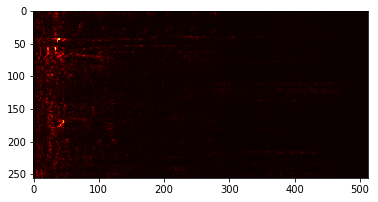

In [43]:
# Test the pipeline still works
m = sess.run(mixed_spec)

plt.imshow(m[0, :, :, 2])

complex_spec = np.empty((m.shape[1], m.shape[2]), dtype=complex)
complex_spec.real = m[0, :, :, 0]
complex_spec.imag = m[0, :, :, 1]

m_wave = librosa.istft(complex_spec.T, fft_hop)
ipd.Audio(m_wave.T, rate=sample_rate)

In [43]:
mix_mag, mix_phase, voice_mag, voice_est_mag, \
    mask, voice_wave, mix_wave, cost = sess.run([model.mixed_mag, 
                                                 model.mixed_phase, 
                                                 model.voice_mag,
                                                 model.gen_voice, 
                                                 model.voice_mask, 
                                                 model.voice_audio, 
                                                 model.mixed_audio,
                                                 model.cost],
                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

In [69]:
# For magnitude and phase
for i in range(voice_mag.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est_mag[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)
    

In [44]:
# For real and imaginary

complex_spec = np.empty((voice_est_mag.shape[0], voice_est_mag.shape[1], voice_est_mag.shape[2]), dtype=complex)
complex_spec.real = voice_est_mag[:, :, :, 0]
complex_spec.imag = voice_est_mag[:, :, :, 1]

for i in range(complex_spec.shape[0]):
    wave = librosa.istft(complex_spec[i].T, fft_hop)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

In [70]:
voice_est_mag.shape

(5, 256, 512, 2)

In [60]:
mix_mag.shape

(5, 256, 512, 2)

In [58]:
ipd.Audio(voice_est_wave[0].T, rate=sample_rate)

In [91]:
def l1(x, y):
    return np.mean(np.abs(x - y))

print(l1(voice_est_mag[0,:,:,0], voice_mag[0,:,:,0]))
print(cost)

4.508612e-05
0.85150206


In [93]:
def phase_loss(x, y):
    
    original_dif = np.abs(x - y)
    add_2_pi_dif = np.abs(x - (y + 2 * math.pi))
    minus_2_pi_dif = np.abs(x - (y - 2 * math.pi))

    corrected_dif = np.minimum(original_dif, np.minimum(add_2_pi_dif, minus_2_pi_dif))

    return np.mean(corrected_dif)

print(phase_loss(voice_est_mag[0,:,:,1], voice_mag[0,:,:,1]))

1.566881


In [98]:
voice_mag[0,:,:,1].min()

-3.1415927

In [97]:
2 * math.pi

6.283185307179586

In [100]:
voice_mag[0,:,:,0].max()

0.0057107

In [45]:
mag_range = voice_mag[0,:,:,0].max() - voice_mag[0,:,:,0].min()
phase_range = voice_mag[0,:,:,1].max() - voice_mag[0,:,:,1].min()
print(mag_range, '\n', phase_range)

0.0110183 
 0.009891857


In [104]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 1800
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        #_, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                       empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))

start: 2018-11-01 15:48:52.480312
Epoch 0 finished. Mean cost = 0.06375576555728912
Epoch 1 finished. Mean cost = 0.0637369453907013
Epoch 2 finished. Mean cost = 0.06372610479593277
Epoch 3 finished. Mean cost = 0.06368689239025116
Epoch 4 finished. Mean cost = 0.06361243724822999
Epoch 5 finished. Mean cost = 0.06355179597934087
Epoch 6 finished. Mean cost = 0.06349054617541176
Epoch 7 finished. Mean cost = 0.06344042718410492
Epoch 8 finished. Mean cost = 0.0633911391099294
Epoch 9 finished. Mean cost = 0.06335217654705047
Epoch 10 finished. Mean cost = 0.06329993768171831
Epoch 11 finished. Mean cost = 0.06324159602324168
Epoch 12 finished. Mean cost = 0.06318341711392769
Epoch 13 finished. Mean cost = 0.06313361280730792
Epoch 14 finished. Mean cost = 0.06308207859595617
Epoch 15 finished. Mean cost = 0.06303892424330115
Epoch 16 finished. Mean cost = 0.0629876707406605
Epoch 17 finished. Mean cost = 0.06293400294250912
Epoch 18 finished. Mean cost = 0.0628800617628976
Epoch 19 fi

Epoch 159 finished. Mean cost = 0.05865592460613698
Epoch 160 finished. Mean cost = 0.05863557982703914
Epoch 161 finished. Mean cost = 0.05861578849546703
Epoch 162 finished. Mean cost = 0.05859640512638297
Epoch 163 finished. Mean cost = 0.05857644909311358
Epoch 164 finished. Mean cost = 0.05855718191825982
Epoch 165 finished. Mean cost = 0.05853742392486837
Epoch 166 finished. Mean cost = 0.05851917160663776
Epoch 167 finished. Mean cost = 0.058501038123809156
Epoch 168 finished. Mean cost = 0.05848334575369513
Epoch 169 finished. Mean cost = 0.0584642932695501
Epoch 170 finished. Mean cost = 0.058445079742293606
Epoch 171 finished. Mean cost = 0.05842557088147069
Epoch 172 finished. Mean cost = 0.05840616294242054
Epoch 173 finished. Mean cost = 0.05838680725501871
Epoch 174 finished. Mean cost = 0.058367973927940645
Epoch 175 finished. Mean cost = 0.058349466120654885
Epoch 176 finished. Mean cost = 0.05833179259535957
Epoch 177 finished. Mean cost = 0.05831344837971618
Epoch 178

Epoch 316 finished. Mean cost = 0.05631237467662769
Epoch 317 finished. Mean cost = 0.056300628274304314
Epoch 318 finished. Mean cost = 0.05628881582458939
Epoch 319 finished. Mean cost = 0.05627723464276642
Epoch 320 finished. Mean cost = 0.05626538767250156
Epoch 321 finished. Mean cost = 0.05625357919644495
Epoch 322 finished. Mean cost = 0.05624196954048455
Epoch 323 finished. Mean cost = 0.05623091787191821
Epoch 324 finished. Mean cost = 0.05621979570159545
Epoch 325 finished. Mean cost = 0.05620946646010949
Epoch 326 finished. Mean cost = 0.05619880904526156
Epoch 327 finished. Mean cost = 0.05618840867153755
Epoch 328 finished. Mean cost = 0.056177520224298026
Epoch 329 finished. Mean cost = 0.056166721936879736
Epoch 330 finished. Mean cost = 0.056155834301991045
Epoch 331 finished. Mean cost = 0.05614503707557199
Epoch 332 finished. Mean cost = 0.05613380197334934
Epoch 333 finished. Mean cost = 0.05612270126933466
Epoch 334 finished. Mean cost = 0.056111469342192605
Epoch 3

Epoch 473 finished. Mean cost = 0.05483126090171468
Epoch 474 finished. Mean cost = 0.05482352408139329
Epoch 475 finished. Mean cost = 0.054815839091707175
Epoch 476 finished. Mean cost = 0.05480834950284888
Epoch 477 finished. Mean cost = 0.05480052072508066
Epoch 478 finished. Mean cost = 0.05479293000847412
Epoch 479 finished. Mean cost = 0.054785049776546656
Epoch 480 finished. Mean cost = 0.05477731381378402
Epoch 481 finished. Mean cost = 0.05476959052020336
Epoch 482 finished. Mean cost = 0.05476205752040288
Epoch 483 finished. Mean cost = 0.05475418042576264
Epoch 484 finished. Mean cost = 0.05474643227212208
Epoch 485 finished. Mean cost = 0.05473850836877715
Epoch 486 finished. Mean cost = 0.0547309013072103
Epoch 487 finished. Mean cost = 0.05472311298133897
Epoch 488 finished. Mean cost = 0.05471549727068357
Epoch 489 finished. Mean cost = 0.05470773858987555
Epoch 490 finished. Mean cost = 0.054700179302461766
Epoch 491 finished. Mean cost = 0.054692612226477
Epoch 492 fi

Epoch 630 finished. Mean cost = 0.05375075693907904
Epoch 631 finished. Mean cost = 0.053744575828078046
Epoch 632 finished. Mean cost = 0.05373841874878177
Epoch 633 finished. Mean cost = 0.0537323660278922
Epoch 634 finished. Mean cost = 0.05372617902952855
Epoch 635 finished. Mean cost = 0.05371994891280086
Epoch 636 finished. Mean cost = 0.05371378034095936
Epoch 637 finished. Mean cost = 0.05370763514109166
Epoch 638 finished. Mean cost = 0.053701734657112234
Epoch 639 finished. Mean cost = 0.053695860726293176
Epoch 640 finished. Mean cost = 0.05369000976059626
Epoch 641 finished. Mean cost = 0.053683935684903386
Epoch 642 finished. Mean cost = 0.053677916080686575
Epoch 643 finished. Mean cost = 0.05367188329767922
Epoch 644 finished. Mean cost = 0.05366588800336963
Epoch 645 finished. Mean cost = 0.053660157975674416
Epoch 646 finished. Mean cost = 0.053654203700964014
Epoch 647 finished. Mean cost = 0.05364823635713554
Epoch 648 finished. Mean cost = 0.05364219619331448
Epoch 

Epoch 787 finished. Mean cost = 0.05289011006598091
Epoch 788 finished. Mean cost = 0.05288516429308401
Epoch 789 finished. Mean cost = 0.05288014816992645
Epoch 790 finished. Mean cost = 0.05287514894013911
Epoch 791 finished. Mean cost = 0.05287005989859351
Epoch 792 finished. Mean cost = 0.05286507020982788
Epoch 793 finished. Mean cost = 0.05286016209187075
Epoch 794 finished. Mean cost = 0.0528553695048926
Epoch 795 finished. Mean cost = 0.0528504149379892
Epoch 796 finished. Mean cost = 0.05284548915427183
Epoch 797 finished. Mean cost = 0.05284054663247034
Epoch 798 finished. Mean cost = 0.05283566921464493
Epoch 799 finished. Mean cost = 0.05283067033626139
Epoch 800 finished. Mean cost = 0.052825751943460265
Epoch 801 finished. Mean cost = 0.05282084079937745
Epoch 802 finished. Mean cost = 0.0528160140642045
Epoch 803 finished. Mean cost = 0.05281115200982165
Epoch 804 finished. Mean cost = 0.052806202493469165
Epoch 805 finished. Mean cost = 0.05280121373331576
Epoch 806 fin

Epoch 945 finished. Mean cost = 0.052171208728380485
Epoch 946 finished. Mean cost = 0.05216713586415006
Epoch 947 finished. Mean cost = 0.052162927705087236
Epoch 948 finished. Mean cost = 0.052158736650320704
Epoch 949 finished. Mean cost = 0.052154461792425104
Epoch 950 finished. Mean cost = 0.052150266861971994
Epoch 951 finished. Mean cost = 0.052145964305597446
Epoch 952 finished. Mean cost = 0.052141756972479796
Epoch 953 finished. Mean cost = 0.0521375702760442
Epoch 954 finished. Mean cost = 0.05213351575804007
Epoch 955 finished. Mean cost = 0.052129256332519164
Epoch 956 finished. Mean cost = 0.052125062443152494
Epoch 957 finished. Mean cost = 0.05212083683273364
Epoch 958 finished. Mean cost = 0.052116739846245465
Epoch 959 finished. Mean cost = 0.05211263173259795
Epoch 960 finished. Mean cost = 0.05210866095279183
Epoch 961 finished. Mean cost = 0.05210453660659136
Epoch 962 finished. Mean cost = 0.05210053297156238
Epoch 963 finished. Mean cost = 0.05209647258936864
Epo

Epoch 1100 finished. Mean cost = 0.05156662654162103
Epoch 1101 finished. Mean cost = 0.05156291130179719
Epoch 1102 finished. Mean cost = 0.051559228277811654
Epoch 1103 finished. Mean cost = 0.05155556414789264
Epoch 1104 finished. Mean cost = 0.05155198243678425
Epoch 1105 finished. Mean cost = 0.05154822347769901
Epoch 1106 finished. Mean cost = 0.051544477932606074
Epoch 1107 finished. Mean cost = 0.051540782359102574
Epoch 1108 finished. Mean cost = 0.05153715749572697
Epoch 1109 finished. Mean cost = 0.05153349213771992
Epoch 1110 finished. Mean cost = 0.051529906167037634
Epoch 1111 finished. Mean cost = 0.051526252478495134
Epoch 1112 finished. Mean cost = 0.05152268172555535
Epoch 1113 finished. Mean cost = 0.05151906691464851
Epoch 1114 finished. Mean cost = 0.05151548185490172
Epoch 1115 finished. Mean cost = 0.0515118266312292
Epoch 1116 finished. Mean cost = 0.05150815054787625
Epoch 1117 finished. Mean cost = 0.05150446437019355
Epoch 1118 finished. Mean cost = 0.0515008

Epoch 1254 finished. Mean cost = 0.051036682778383156
Epoch 1255 finished. Mean cost = 0.05103349779394402
Epoch 1256 finished. Mean cost = 0.05103026901860036
Epoch 1257 finished. Mean cost = 0.05102712023464314
Epoch 1258 finished. Mean cost = 0.051023916735641536
Epoch 1259 finished. Mean cost = 0.051020815318065973
Epoch 1260 finished. Mean cost = 0.051017601394539876
Epoch 1261 finished. Mean cost = 0.05101441417225945
Epoch 1262 finished. Mean cost = 0.0510111745662238
Epoch 1263 finished. Mean cost = 0.051008020076735675
Epoch 1264 finished. Mean cost = 0.051004839523625466
Epoch 1265 finished. Mean cost = 0.05100169007800296
Epoch 1266 finished. Mean cost = 0.05099841317819062
Epoch 1267 finished. Mean cost = 0.050995120643535244
Epoch 1268 finished. Mean cost = 0.05099186004147556
Epoch 1269 finished. Mean cost = 0.05098868840205388
Epoch 1270 finished. Mean cost = 0.050985424256906275
Epoch 1271 finished. Mean cost = 0.05098219211184004
Epoch 1272 finished. Mean cost = 0.0509

Epoch 1408 finished. Mean cost = 0.050563381026407096
Epoch 1409 finished. Mean cost = 0.0505604661948292
Epoch 1410 finished. Mean cost = 0.050557532319356835
Epoch 1411 finished. Mean cost = 0.05055459495897671
Epoch 1412 finished. Mean cost = 0.05055159850274091
Epoch 1413 finished. Mean cost = 0.050548600309556074
Epoch 1414 finished. Mean cost = 0.05054561373096473
Epoch 1415 finished. Mean cost = 0.050542683040691636
Epoch 1416 finished. Mean cost = 0.05053972767832924
Epoch 1417 finished. Mean cost = 0.050536814577909046
Epoch 1418 finished. Mean cost = 0.05053388259102544
Epoch 1419 finished. Mean cost = 0.05053097496832341
Epoch 1420 finished. Mean cost = 0.05052810895566702
Epoch 1421 finished. Mean cost = 0.050525178142552134
Epoch 1422 finished. Mean cost = 0.0505222553545668
Epoch 1423 finished. Mean cost = 0.050519283481591036
Epoch 1424 finished. Mean cost = 0.05051630231633521
Epoch 1425 finished. Mean cost = 0.050513335515393616
Epoch 1426 finished. Mean cost = 0.05051

Epoch 1562 finished. Mean cost = 0.050134442923012563
Epoch 1563 finished. Mean cost = 0.05013168719418518
Epoch 1564 finished. Mean cost = 0.05012894779824601
Epoch 1565 finished. Mean cost = 0.05012628791965592
Epoch 1566 finished. Mean cost = 0.050123586896486015
Epoch 1567 finished. Mean cost = 0.05012090454514766
Epoch 1568 finished. Mean cost = 0.0501181221976069
Epoch 1569 finished. Mean cost = 0.050115399447026525
Epoch 1570 finished. Mean cost = 0.05011279722124357
Epoch 1571 finished. Mean cost = 0.05011033754246001
Epoch 1572 finished. Mean cost = 0.050107736884126675
Epoch 1573 finished. Mean cost = 0.05010516875514612
Epoch 1574 finished. Mean cost = 0.05010253553116133
Epoch 1575 finished. Mean cost = 0.05009998552510657
Epoch 1576 finished. Mean cost = 0.05009731609957764
Epoch 1577 finished. Mean cost = 0.05009463760902673
Epoch 1578 finished. Mean cost = 0.05009195317076006
Epoch 1579 finished. Mean cost = 0.050089314490368096
Epoch 1580 finished. Mean cost = 0.0500866

Epoch 1716 finished. Mean cost = 0.04974197740810308
Epoch 1717 finished. Mean cost = 0.04973956104693229
Epoch 1718 finished. Mean cost = 0.0497370795360341
Epoch 1719 finished. Mean cost = 0.049734638956223806
Epoch 1720 finished. Mean cost = 0.04973213475052525
Epoch 1721 finished. Mean cost = 0.04972962551814061
Epoch 1722 finished. Mean cost = 0.049727162487861104
Epoch 1723 finished. Mean cost = 0.04972473577339107
Epoch 1724 finished. Mean cost = 0.04972225675548332
Epoch 1725 finished. Mean cost = 0.049719804498611984
Epoch 1726 finished. Mean cost = 0.04971730325114333
Epoch 1727 finished. Mean cost = 0.04971480960267837
Epoch 1728 finished. Mean cost = 0.049712362426116055
Epoch 1729 finished. Mean cost = 0.049710000870544786
Epoch 1730 finished. Mean cost = 0.04970755288189095
Epoch 1731 finished. Mean cost = 0.0497052081565934
Epoch 1732 finished. Mean cost = 0.04970283901767104
Epoch 1733 finished. Mean cost = 0.04970067423245211
Epoch 1734 finished. Mean cost = 0.04969831

In [105]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                 model.mixed_phase, 
                                                                                 model.voice_input,
                                                                                 model.gen_voice, 
                                                                                 model.voice_mask, 
                                                                                 model.voice_audio, 
                                                                                 model.mixed_audio],
                                                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     #fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
                                     fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

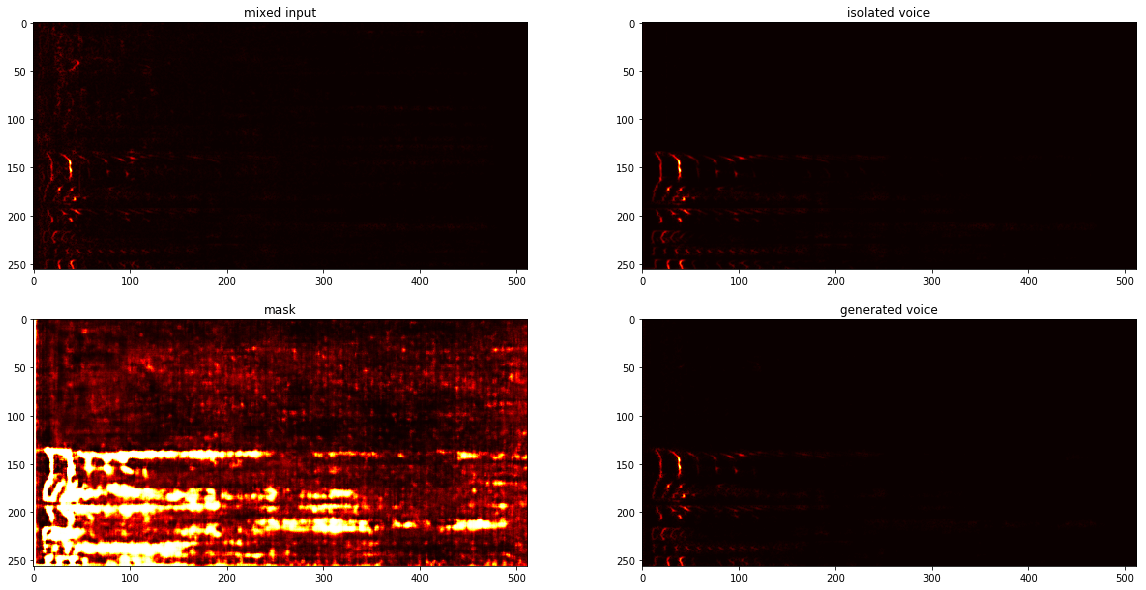

In [80]:
i=1

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_inp[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

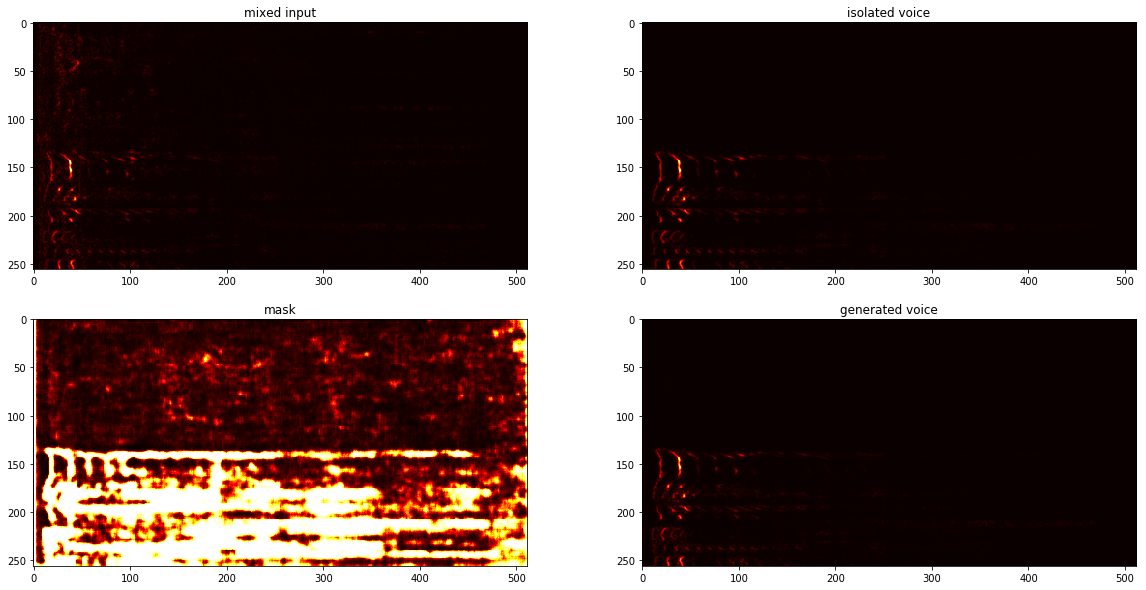

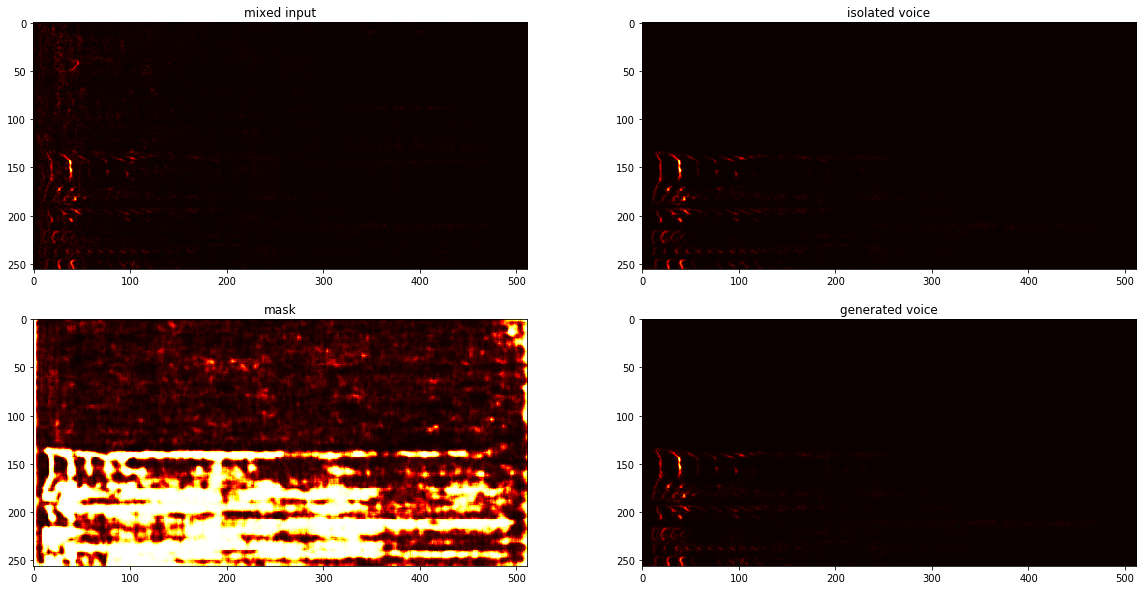

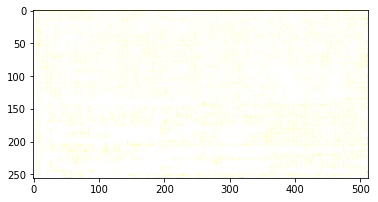

In [65]:
plt.imshow(mask[i,:,:,1])

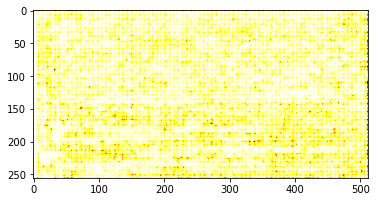

In [114]:
i=1
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

5
65280


5
65280


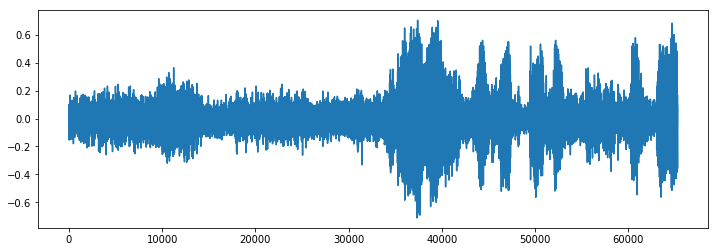

In [48]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

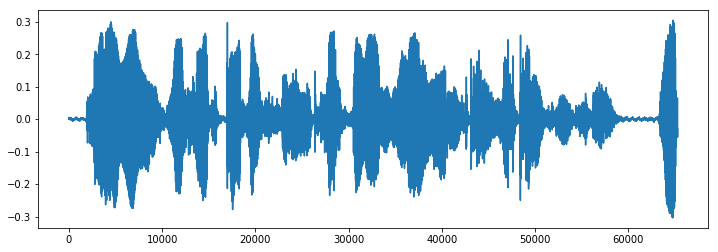

In [110]:
#  The true isolated voice 
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

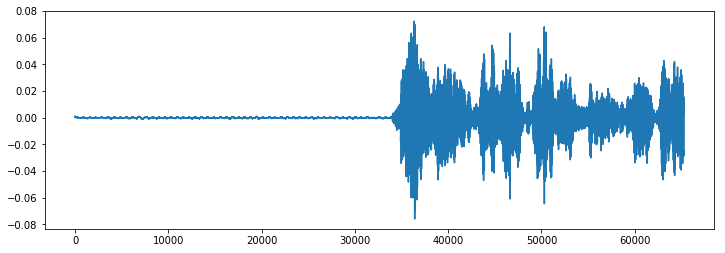

In [115]:
#  The estimated isolated voice produced by the network - real_imag
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

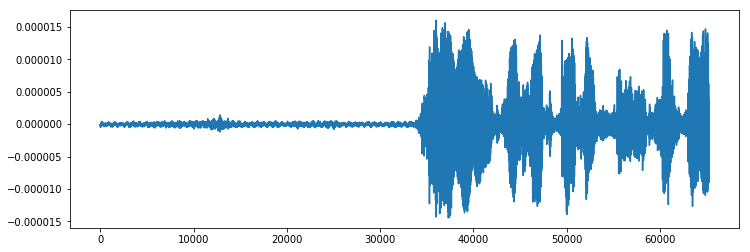

In [82]:
#  The estimated isolated voice produced by the network - mag
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

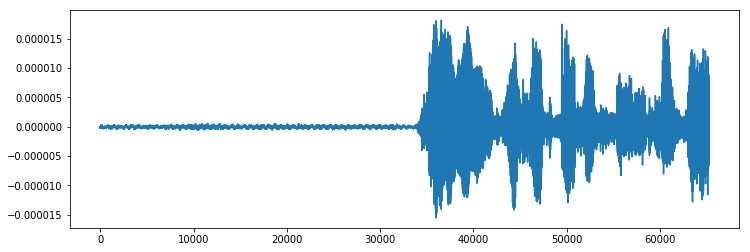

In [66]:
#  The estimated isolated voice produced by the network - mag_phse_diff
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

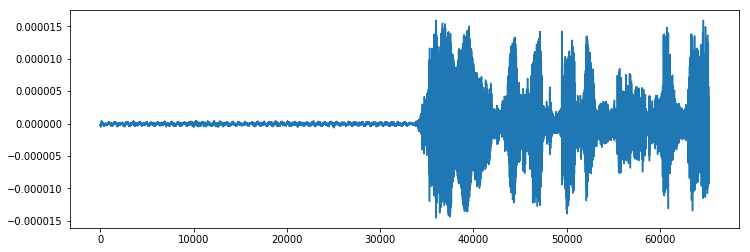

In [26]:
#  The estimated isolated voice produced by the network - mag_phase
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)